In [359]:
import numpy as np
import imageio
import sys
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
imageio.plugins.freeimage.download()
import scipy.stats as st
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [173]:

def load_normal_reals(file):
    normal_files = glob.glob(file)[:100]

    normals = []
    print(len(normal_files))
    for normal_file in normal_files:
        imarr = imageio.imread(normal_file)[1:-1,1:-1,:]
        imarr[~np.isfinite(imarr)] = 0
        normals.append((imarr.reshape(-1, 3) - 0.5) * 2)

    normals = np.array(normals)
    return normals

<ipython-input-362-e40b7355bdca>:31: RuntimeWarning: invalid value encountered in sqrt
  Z = np.sqrt(1- (XX**2 + YY**2))


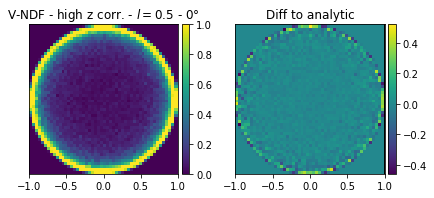

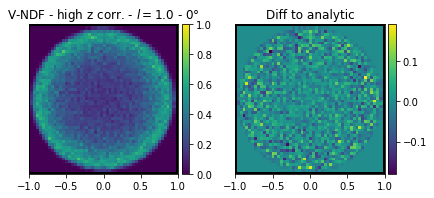

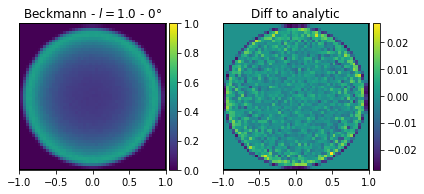

In [362]:
def beckmann(theta, alpha):
    u = np.cos(theta)
    
    alphaSq = alpha*alpha
    cosThetaSq = np.cos(theta)**2
    tanThetaSq = np.maximum(1.0 - cosThetaSq, 0.0)/cosThetaSq
    cosThetaQu = cosThetaSq*cosThetaSq
    res = (1.0/np.pi)*np.exp(-tanThetaSq/alphaSq)/(alphaSq*cosThetaQu)
    
    return np.where(u > 0, res, 0)

def plot_normal_collection(normals, label, beckmann_roughness=0):
    #fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    fig, (ax,ax2) = plt.subplots(1,2)

    hist, X, Y = np.histogram2d(
          normals[:,0], 
          normals[:,1], bins=(50, 50), density=True)

    #A, R = np.meshgrid(abins, rbins)
    pc = ax.pcolormesh(X, Y, hist.T, vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(pc, cax=cax, orientation='vertical')
    
    #fig.colorbar(pc)


    if beckmann_roughness != 0:
        XX,YY = np.meshgrid((X[1:]+X[:-1]) * 0.5, (Y[1:]+Y[:-1]) * 0.5)
        Z = np.sqrt(1- (XX**2 + YY**2))
        b = beckmann(np.arccos(Z), beckmann_roughness)
        pc = ax2.pcolormesh(X, Y, b-hist.T)
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(pc, cax=cax, orientation='vertical')


        ax2.set_ylim(-1,1)
        ax2.set_xlim(-1,1)
        ax2.set_facecolor("black")
        ax2.grid(False)
        ax2.set_yticks([])
        ax2.set_title("Diff to analytic")
        #ax.xlabel("$n_x$")
        #ax.ylabel("$n_y$")
        ax2.set_aspect("equal")
        fig.tight_layout()

    #ax.scatter(np.arctan2(normals[:,1], normals[:,0]), np.sqrt(normals[:,0]**2 + normals[:,1]**2), s=0.2, alpha=0.02, color="white")
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_facecolor("black")
    ax.grid(False)
    ax.set_yticks([])
    ax.set_title(label)
    #ax.xlabel("$n_x$")
    #ax.ylabel("$n_y$")
    ax.set_aspect("equal")
    fig.tight_layout()

def plot_normal_collection_1D(normals, label, beckmann_roughness=0, vmf_kappa=0):
    #fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    fig, ax = plt.subplots()

    # define binning
    rbins = np.linspace(-1, 1, 100)

    hist, bins = np.histogram(normals[:,2], weights=1/(normals.shape[0]*normals[:,2]), bins=rbins, density=False)

    bins = bins[1:]

    hist *= (2.5*np.pi)

    ax.plot(bins, hist, label="sampled")

    if beckmann_roughness != 0:
        b = beckmann(np.arccos(bins), beckmann_roughness)
        plt.plot(bins, b, label='beckmann')

    if vmf_kappa != 0:
        b = st.vonmises.pdf(np.arccos(bins), vmf_kappa)
        plt.plot(bins, b, label='vMF')

    #ax.set_xlim(-1,1)
    ax.grid(False)
    ax.set_title(label)
    ax.set_xlabel("$n_z$")
    ax.legend()
    #ax.ylabel("$n_y$")
    #ax.set_theta_zero_location("N")
    #ax.set_aspect("equal")
    fig.tight_layout()
    

def br(L2):
    return np.sqrt(2*L2)

normals = np.reshape(np.fromfile('visible-normals/0-surface-l=0.5.bin', dtype=np.float32), (3,-1)).T
plot_normal_collection(normals, "V-NDF - high z corr. - $l=0.5$ - $0\\degree$", beckmann_roughness = br(4))

normals = np.reshape(np.fromfile('visible-normals/0-surface-l=1.0-f3.bin', dtype=np.float32), (3,-1)).T
plot_normal_collection(normals, "V-NDF - high z corr. - $l=1.0$ - $0\\degree$", beckmann_roughness =  1.41421)

normals = np.reshape(np.fromfile('visible-normals/beckmann.bin', dtype=np.float32), (3,-1)).T
plot_normal_collection(normals, "Sampled Beckmann - $l=1.0$ - $0\\degree$", beckmann_roughness =  1.41421)

# normals = np.reshape(np.fromfile('visible-normals/0-surface-l=1.25.bin', dtype=np.float32), (3,-1)).T
# plot_normal_collection_1D(normals, "V-NDF - high z corr. - $l=1.25$ - $0\\degree$", beckmann_roughness =  1.13137)

# a = br(0.25)
# normals = np.reshape(np.fromfile('visible-normals/0-surface-l=2.0.bin', dtype=np.float32), (3,-1)).T
# plot_normal_collection_1D(normals, "V-NDF - high z corr. - $l=2.0$ - $0\\degree$", beckmann_roughness =  a)

# normals = np.reshape(np.fromfile('visible-normals/0-surface-l=2.0-f.bin', dtype=np.float32), (3,-1)).T
# plot_normal_collection_1D(normals, "V-NDF - high z corr. - $l=2.0$ - $0\\degree$", beckmann_roughness =  a)

# normals = np.reshape(np.fromfile('visible-normals/0-surface-l=3.0.bin', dtype=np.float32), (3,-1)).T
# plot_normal_collection_1D(normals, "V-NDF - high z corr. - $l=3.0$ - $0\\degree$", beckmann_roughness =  0.471405)


# normals = np.reshape(np.fromfile('visible-normals/45-blobbs-l=1.0-a=1.0.bin', dtype=np.float32), (3,-1)).T
# plot_normal_collection_1D(normals, "V-NDF - low z corr. - $l=1.0$ - $45\\degree$")

# normals = np.reshape(np.fromfile('visible-normals/0-blobbs-l=1.0-a=1.0.bin', dtype=np.float32), (3,-1)).T
# plot_normal_collection_1D(normals, "V-NDF - low z corr. - $l=1.0$ - $0\\degree$")



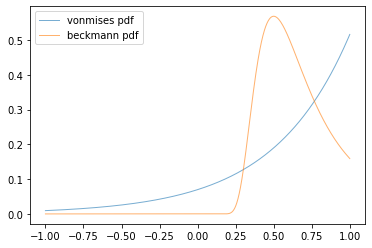

In [293]:




kappa = 2

u = np.linspace(-1, 1, 1000)
pdf = st.vonmises.pdf(np.arccos(u), kappa)

b = beckmann(np.arccos(u), 1.41421)

#z = np.cos(theta)
#pdf = pdf * np.sin(theta)


plt.plot(u, pdf, lw=1, alpha=0.6, label='vonmises pdf')
plt.plot(u, b, lw=1, alpha=0.6, label='beckmann pdf')
plt.legend()